In [1]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, VarianceThreshold
import matplotlib.pyplot as plt
import seaborn as sns

<br/>
Uncomment the following cell to always display the whole dataframe, but this makes my laptop run slowly.

In [2]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.expand_frame_repr', False) 
# pd.set_option('display.max_colwidth', None)

# Data cleaning
Read training, test, evaluation sets, check whether there exist nulls or abnormal values. It seems that the given datasets are very clean.

In [3]:
training_set = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')
evaluation_set = pd.read_csv('evaluation.csv')

print(training_set['score'].value_counts(), '\n', # This is to count all different values in 'score'.
      training_set.isna().sum())                  # This is to count all nulls.
print(' ')
print(test_set['score'].value_counts(), '\n',
      test_set.isna().sum())
print(' ')
print(evaluation_set['score'].value_counts(), '\n',
      evaluation_set.isna().sum())

1    3752
0    3748
Name: score, dtype: int64 
 score    0
text     0
dtype: int64
 
0    1252
1    1248
Name: score, dtype: int64 
 score    0
text     0
dtype: int64
 
1    2518
0    2482
Name: score, dtype: int64 
 score    0
text     0
dtype: int64



<br/>
Defining a function for cleaning the 'text' feature.


In [4]:
def clean_text(text):
    text = re.sub(r'<.*?>', ' ', text)                           # substitute HTML tags with spaces
    text = re.sub(r'@[\w_]+', ' ', text)                         # substitute mentions with spaces
    text = re.sub(r'http[s]?://\S+|www\.\S+', ' ', text)         # substitute URLs with spaces
    text = re.sub(r'[^\w\s\d\U0001F000-\U0001F9FF]', ' ', text)  # substitute punctuations with spaces
    return text

<br/>
Apply clean_text function to all datasets.

In [5]:
training_set['text'] = training_set['text'].apply(clean_text)
test_set['text'] = test_set['text'].apply(clean_text)
evaluation_set['text'] = evaluation_set['text'].apply(clean_text)

# Feature engineering
Use TF-IDF to encode the 'text' features, with 6000 as max features, 'english' library as stop words, and consider both 1 and 2 grams. The encoding method is then fit for the training set and saved in tfidf_vectorizer. After that, use the same tfidf_vectorizer (the same encoding method) to encode the test and evaluation set.

In [6]:
# tfidf_vectorizer = TfidfVectorizer(max_features=6000, stop_words='english', ngram_range=(1, 2))

# X_train = tfidf_vectorizer.fit_transform(training_set['text'])
# y_train = training_set['score']

# X_test = tfidf_vectorizer.transform(test_set['text'])
# y_test = test_set['score']

# X_evaluation = tfidf_vectorizer.transform(evaluation_set['text'])
# y_evaluation = evaluation_set['score']

<br/>
An interesting trial with unlimited max features and no stop words for TfidfVectorizer, and save it as tfidf_vectorizer_trial.

In [7]:
tfidf_vectorizer_trial = TfidfVectorizer(ngram_range=(1, 2))

X_train_trial = tfidf_vectorizer_trial.fit_transform(training_set['text'])
y_train_trial = training_set['score']

X_test_trial = tfidf_vectorizer_trial.transform(test_set['text'])
y_test_trial = test_set['score']

X_evaluation_trial = tfidf_vectorizer_trial.transform(evaluation_set['text'])
y_evaluation_trial = evaluation_set['score']

# Training
Use MultnomialNB as the naive bayes classifier. Apply grid search with 5-fold cross validation to find the best smoothing paramter alpha for MultnomialNB. It turns out that the best alpha is 2.9.

In [8]:
# param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 2.8, 2.9, 3.0, 4.0]}
# grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5)
# grid_search.fit(X_train, y_train)

# best_alpha = grid_search.best_params_['alpha']
# best_alpha

<br/>
For the trial with tfidf_vectorizer_trial, this time the best alpha is 0.2:

In [9]:
param_grid_trial = {'alpha': [0.1, 0.2, 0.3, 0.5, 1.0]}
grid_search_trial = GridSearchCV(MultinomialNB(), param_grid_trial, cv=5)
grid_search_trial.fit(X_train_trial, y_train_trial)

best_alpha_trial = grid_search_trial.best_params_['alpha']
best_alpha_trial

0.2

<br/>
Then train MultinomialNB with the best alpha 2.9, and save the model as nb_classifier.

In [10]:
# nb_classifier = MultinomialNB(alpha=best_alpha)
# nb_classifier.fit(X_train, y_train)

<br/>
For the trial with best_alpha_trial:

In [11]:
nb_classifier_trial = MultinomialNB(alpha=best_alpha_trial)
nb_classifier_trial.fit(X_train_trial, y_train_trial)

MultinomialNB(alpha=0.2)

<br/>
Based on what we got from lab 1, the trial one with no stop words works better, thus only consider this one in lab 2.

# Testing and evaluation
Use nb_classifier to predict for test and evaluation set, and check the accuracy.

In [12]:
# y_pred = nb_classifier.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# print(accuracy)

In [13]:
# y_pred_evaluation = nb_classifier.predict(X_evaluation)

# accuracy_evaluation = accuracy_score(y_evaluation, y_pred_evaluation)
# print(accuracy_evaluation)

<br/>
For the trial with tfidf_vectorizer_trial:

In [14]:
y_pred_trial = nb_classifier_trial.predict(X_test_trial)

accuracy_trial = accuracy_score(y_test_trial, y_pred_trial)
print(accuracy_trial)
print(classification_report(y_test_trial, y_pred_trial))

0.8492
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1252
           1       0.89      0.80      0.84      1248

    accuracy                           0.85      2500
   macro avg       0.85      0.85      0.85      2500
weighted avg       0.85      0.85      0.85      2500



In [15]:
y_pred_evaluation_trial = nb_classifier_trial.predict(X_evaluation_trial)

accuracy_evaluation_trial = accuracy_score(y_evaluation_trial, y_pred_evaluation_trial)
print(accuracy_evaluation_trial)
print(classification_report(y_evaluation_trial, y_pred_evaluation_trial))

0.839
              precision    recall  f1-score   support

           0       0.78      0.94      0.85      2482
           1       0.92      0.74      0.82      2518

    accuracy                           0.84      5000
   macro avg       0.85      0.84      0.84      5000
weighted avg       0.85      0.84      0.84      5000



<br/>
Calculate AUC values and plot ROC curves.

In [16]:
# y_prob_test = nb_classifier.predict_proba(X_test)[:, 1]  # obtain probability of positive
# fpr_test_1, tpr_test_1, _ = roc_curve(y_test, y_prob_test)
# auc_test_1 = roc_auc_score(y_test, y_prob_test)

# y_prob_test_trial = nb_classifier_trial.predict_proba(X_test_trial)[:, 1] 
# fpr_test_2, tpr_test_2, _ = roc_curve(y_test_trial, y_prob_test_trial)
# auc_test_2 = roc_auc_score(y_test_trial, y_prob_test_trial)

# y_prob_evaluation = nb_classifier.predict_proba(X_evaluation)[:, 1]
# fpr_evaluation_1, tpr_evaluation_1, _ = roc_curve(y_evaluation, y_prob_evaluation)
# auc_evaluation_1 = roc_auc_score(y_evaluation, y_prob_evaluation)

# y_prob_evaluation_trial = nb_classifier_trial.predict_proba(X_evaluation_trial)[:, 1]
# fpr_evaluation_2, tpr_evaluation_2, _ = roc_curve(y_evaluation_trial, y_prob_evaluation_trial)
# auc_evaluation_2 = roc_auc_score(y_evaluation_trial, y_prob_evaluation_trial)

In [17]:
# plt.figure(figsize=(10, 8))
# plt.plot(fpr_test_1, tpr_test_1, label=f'Test Model (AUC = {auc_test_1:.2f})')
# plt.plot(fpr_test_2, tpr_test_2, label=f'Test Model with Trial (AUC = {auc_test_2:.2f})')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve - Test Set')
# plt.legend()
# plt.show()

# plt.figure(figsize=(10, 8))
# plt.plot(fpr_evaluation_1, tpr_evaluation_1, label=f'Evaluation Model (AUC = {auc_evaluation_1:.2f})')
# plt.plot(fpr_evaluation_2, tpr_evaluation_2, label=f'Evaluation Model with Trial (AUC = {auc_evaluation_2:.2f})')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve - Evaluation Set')
# plt.legend()
# plt.show()

<br/>
In the end, plot the confusion matrices here.

In [18]:
# cm_test_1 = confusion_matrix(y_test, y_pred)

# cm_test_2 = confusion_matrix(y_test_trial, y_pred_trial)

# cm_evaluation_1 = confusion_matrix(y_evaluation, y_pred_evaluation)

# cm_evaluation_2 = confusion_matrix(y_evaluation_trial, y_pred_evaluation_trial)

# plt.figure(figsize=(8, 6))
# sns.heatmap(cm_test_1, annot=True, fmt='d', cmap='Blues', cbar=False)
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix - Test Set')
# plt.show()

# plt.figure(figsize=(8, 6))
# sns.heatmap(cm_test_2, annot=True, fmt='d', cmap='Blues', cbar=False)
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix - Test Set with Trial')
# plt.show()

# plt.figure(figsize=(8, 6))
# sns.heatmap(cm_evaluation_1, annot=True, fmt='d', cmap='Blues', cbar=False)
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix - Evaluation Set')
# plt.show()

# plt.figure(figsize=(8, 6))
# sns.heatmap(cm_evaluation_2, annot=True, fmt='d', cmap='Blues', cbar=False)
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix - Evaluation Set with Trial')
# plt.show()

# SVM
After that, let's come to lab 2 SVM. Similarly, we use TF-IDF to encode the text, pay attention to the max features and the usage of stop words. Besides, select k best features from the vectorized training set based on different criteria.

In [19]:
tfidf_vectorizer_svm = TfidfVectorizer(max_features=5000)

X_train_svm = tfidf_vectorizer_svm.fit_transform(training_set['text'])
y_train_svm = training_set['score']

X_test_svm = tfidf_vectorizer_svm.transform(test_set['text'])
y_test_svm = test_set['score']

X_evaluation_svm = tfidf_vectorizer_svm.transform(evaluation_set['text'])
y_evaluation_svm = evaluation_set['score']

k_best = SelectKBest(score_func=chi2, k=1600)  # select k best features from the vectorized training set
# k_best = SelectKBest(score_func=mutual_info_classif, k=1500)
# k_best = VarianceThreshold(threshold=0.0001)
X_train_svm = k_best.fit_transform(X_train_svm, y_train_svm)
X_test_svm = k_best.transform(X_test_svm)
X_evaluation_svm = k_best.transform(X_evaluation_svm)

<br/>
When training the model, use grid search with different combinations of (C: tolerance of soft margin, kernel, gamma for rbf, degree for polynomial).

In [20]:
svm_classifier = SVC(random_state=42, probability=True)

param_grid_svm = {
    'C': [15],
    'kernel': ['rbf'],
    'gamma': [0.1]  # gamma for rbf kernel
    
#     'C': [20],
#     'kernel': ['poly'],
#     'degree': [2]  # degree for polynomial kernel
    
#     'C': [1],
#     'kernel': ['sigmoid']
    
#     'C': [1],
#     'kernel': ['linear']
}

grid_search_svm = GridSearchCV(svm_classifier, param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)

grid_search_svm.fit(X_train_svm, y_train_svm)

results_grid_search_svm = grid_search_svm.cv_results_
for i in range(len(results_grid_search_svm['params'])):
    print(f"Parameters: {results_grid_search_svm['params'][i]}")
    print(f"Mean Test Score (Accuracy): {results_grid_search_svm['mean_test_score'][i]:.4f}")
    print()

print(grid_search_svm.best_params_)

Parameters: {'C': 15, 'gamma': 0.1, 'kernel': 'rbf'}
Mean Test Score (Accuracy): 0.8663

{'C': 15, 'gamma': 0.1, 'kernel': 'rbf'}


<br/>
It seems that select 1600 features based on chi2, use rbf kernel with C=15, gamma=0.1 gives the best result for the test set. Besides, we again didn't use stop words for TfidfVectorizer (notice all parameters for TfidfVectorizer).

In [21]:
best_svm_model = grid_search_svm.best_estimator_
y_pred_svm = best_svm_model.predict(X_test_svm)

accracy_svm = accuracy_score(y_test_svm, y_pred_svm)
print(accracy_svm)
print(classification_report(y_test_svm, y_pred_svm))

0.8588
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1252
           1       0.86      0.85      0.86      1248

    accuracy                           0.86      2500
   macro avg       0.86      0.86      0.86      2500
weighted avg       0.86      0.86      0.86      2500



<br/>
This gives 0.8524 accuracy for the evaluation set.

In [22]:
y_pred_evaluation_svm = best_svm_model.predict(X_evaluation_svm)

accracy_evaluation_svm = accuracy_score(y_evaluation_svm, y_pred_evaluation_svm)
print(accracy_evaluation_svm)
print(classification_report(y_evaluation_svm, y_pred_evaluation_svm))

0.8524
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      2482
           1       0.86      0.84      0.85      2518

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000



<br/>
Calculate AUC values and plot ROC curves.

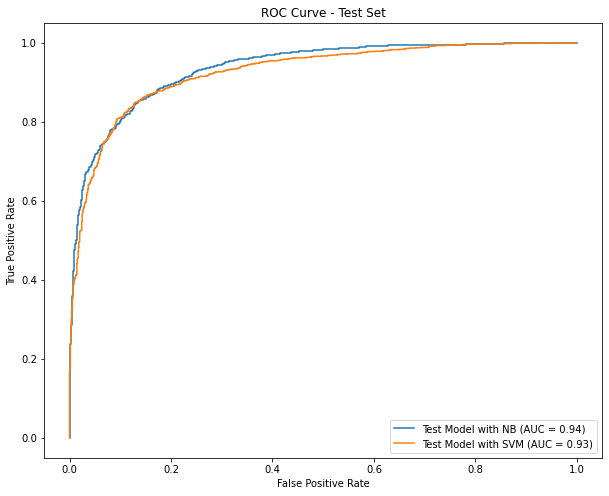

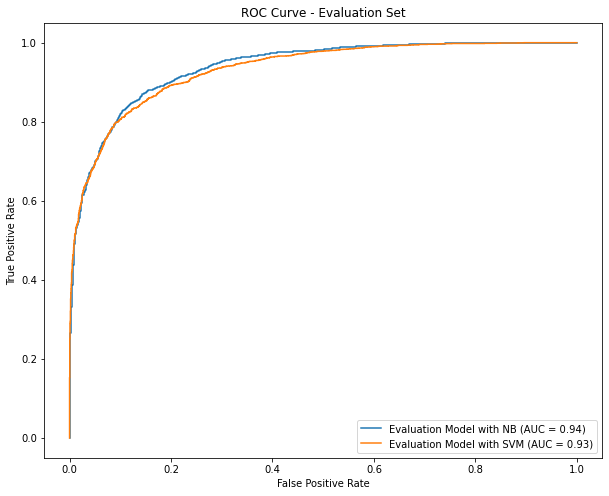

In [23]:
y_prob_test_trial = nb_classifier_trial.predict_proba(X_test_trial)[:, 1]  # obtain probability of positive
fpr_test_1, tpr_test_1, _ = roc_curve(y_test_trial, y_prob_test_trial)
auc_test_1 = roc_auc_score(y_test_trial, y_prob_test_trial)

y_prob_test_svm = best_svm_model.predict_proba(X_test_svm)[:, 1]
fpr_test_2, tpr_test_2, _ = roc_curve(y_test_svm, y_prob_test_svm)
auc_test_2 = roc_auc_score(y_test_svm, y_prob_test_svm)

y_prob_evaluation_trial = nb_classifier_trial.predict_proba(X_evaluation_trial)[:, 1]
fpr_evaluation_1, tpr_evaluation_1, _ = roc_curve(y_evaluation_trial, y_prob_evaluation_trial)
auc_evaluation_1 = roc_auc_score(y_evaluation_trial, y_prob_evaluation_trial)

y_prob_evaluation_svm = best_svm_model.predict_proba(X_evaluation_svm)[:, 1]
fpr_evaluation_2, tpr_evaluation_2, _ = roc_curve(y_evaluation_svm, y_prob_evaluation_svm)
auc_evaluation_2 = roc_auc_score(y_evaluation_svm, y_prob_evaluation_svm)

plt.figure(figsize=(10, 8))
plt.plot(fpr_test_1, tpr_test_1, label=f'Test Model with NB (AUC = {auc_test_1:.2f})')
plt.plot(fpr_test_2, tpr_test_2, label=f'Test Model with SVM (AUC = {auc_test_2:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set')
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(fpr_evaluation_1, tpr_evaluation_1, label=f'Evaluation Model with NB (AUC = {auc_evaluation_1:.2f})')
plt.plot(fpr_evaluation_2, tpr_evaluation_2, label=f'Evaluation Model with SVM (AUC = {auc_evaluation_2:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Evaluation Set')
plt.legend()
plt.show()

<br/>
In the end, plot the confusion matrices here.

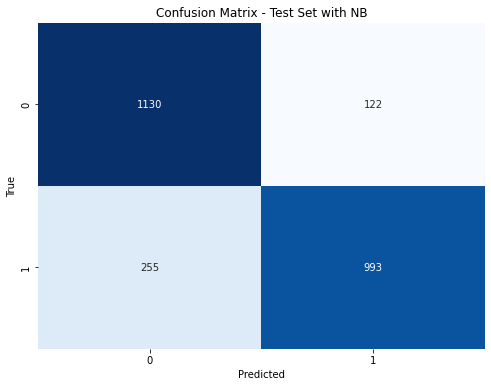

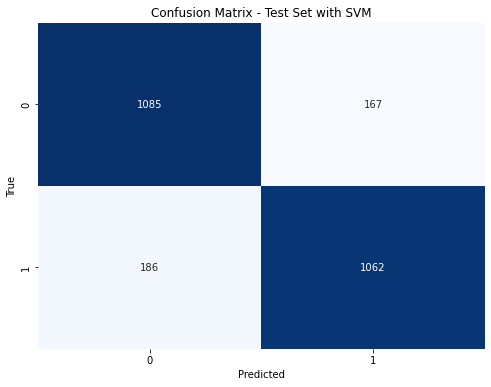

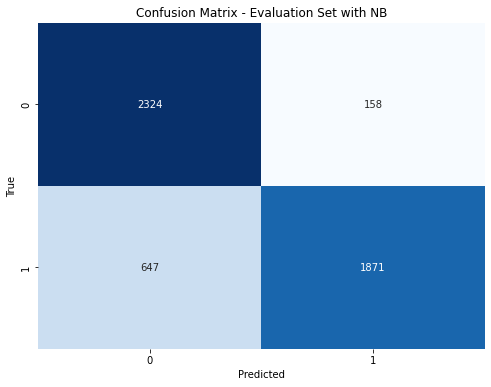

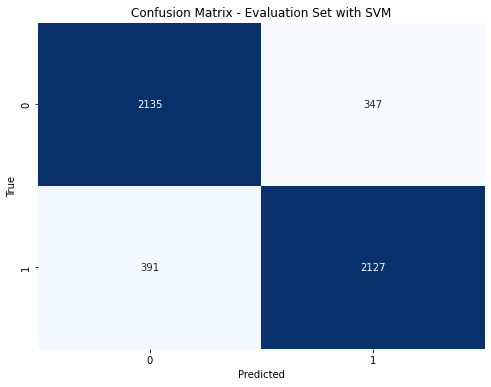

In [24]:
cm_test_1 = confusion_matrix(y_test_trial, y_pred_trial)

cm_test_2 = confusion_matrix(y_test_svm, y_pred_svm)

cm_evaluation_1 = confusion_matrix(y_evaluation_trial, y_pred_evaluation_trial)

cm_evaluation_2 = confusion_matrix(y_evaluation_svm, y_pred_evaluation_svm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_1, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set with NB')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_2, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set with SVM')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(cm_evaluation_1, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Evaluation Set with NB')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(cm_evaluation_2, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Evaluation Set with SVM')
plt.show()